# 1. Import thư viện và dữ liệu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from skopt import BayesSearchCV

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

In [ ]:
store_data = pd.read_csv('./Data Source/store.csv')
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
train_data = pd.read_csv('./Data Source/train.csv', low_memory = False)
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
raw_data = pd.merge(store_data, train_data, how = 'left',on = 'Store')
raw_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1


In [ ]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data.head()
first_data = raw_data[(raw_data['Date'] >= '2014-01-01') & (raw_data['Date'] < '2015-01-01')]
first_data = first_data.reset_index(drop=True)
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2014-12-31,2605,327,1,0,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2014-12-30,6466,703,1,0,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2014-12-29,6463,700,1,0,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2014-12-28,0,0,0,0,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,6,2014-12-27,6057,684,1,0,0,1


- Store: ID của mỗi cửa hàng;
- DayOfWeek: Ngày thứ bao nhiêu trong tuần (thứ 2 đến chủ nhật), thông thường các cửa hàng đóng cửa vào thứ bảy và chủ nhật;
- Date: Thời gian diễn ra hoạt động của cửa hàng;
- Sales: Doanh thu cho bất kỳ ngày nào (Giá trị chúng ta cần dự đoán);
- Customers: Số lượng khách hàng vào một ngày;
- Open: Chỉ báo xem cửa hàng có mở hay không (0: đóng cửa, 1: mở cửa);
- Promo: Cho biết cửa hàng có khuyến mãi vào ngày đó không (0: không có, 1: có);
- StateHoliday: Cho biết ngày lễ của tiểu bang. Trừ một vài ngoại lệ, thông thường các cửa hàng đều đóng cửa vào các ngày lễ của tiểu bang (a: nghỉ lễ, b: lễ Phục sinh, c: Giáng sinh, 0: không);
- SchoolHoliday: Cho biết liệu cửa hàng có bị ảnh hưởng bởi việc đóng cửa, nghỉ lễ của trường công lập không (0: không, 1: có);
- StoreType: Chỉ ra 4 mô hình cửa hàng khác nhau gồm a, b, c, d. Các loại cửa hàng khác nhau thì bán khác sản phẩm;
- Assortment: Mô tả cấp độ phân loại (a: cơ bản, b: bổ sung, c: mở rộng). Cho biết sự đa dạng trong các mặt hàng của cửa hàng;
- CompetitionDistance: Khoảng cách đến đối thủ cạnh tranh gần nhất (tính bằng mét);
- CompetitionOpenSinceMonth: Tháng mà đối thủ cạnh tranh gần nhất được mở
- CompetitionOpenSinceYear: Năm mà đối thủ cạnh tranh gần nhất được mở;
- Promo2: Chương trình khuyến mãi liên tục, liên tiếp cho một số cửa hàng (1: cửa hàng đang tiến hành khuyến mãi, 0: cửa hàng không tiến hành khuyến mãi);
- Promo2SinceWeek: Tuần khi cửa hàng bắt đầu tham gia Promo2;
- Promo2SinceYear: Năm khi cửa hàng bắt đầu tham gia Promo2;
- PromoInterval: Cho biết Promo2 chạy trong những tháng nhất định nào trong năm (khoảng thời gian liên tiếp promo2 được bắt đầu lại).

# 2. Phân tích và khám phá dữ liệu EDA

## 2.1 Khám phá dữ liệu

In [ ]:
print(f'Số cột: {first_data.shape[1]}')
print(f'Số dòng: {first_data.shape[0]}')

Số cột: 18
Số dòng: 373855


In [ ]:
first_data.duplicated().sum()

0

In [ ]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373855 entries, 0 to 373854
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      373855 non-null  int64         
 1   StoreType                  373855 non-null  object        
 2   Assortment                 373855 non-null  object        
 3   CompetitionDistance        372944 non-null  float64       
 4   CompetitionOpenSinceMonth  254765 non-null  float64       
 5   CompetitionOpenSinceYear   254765 non-null  float64       
 6   Promo2                     373855 non-null  int64         
 7   Promo2SinceWeek            179711 non-null  float64       
 8   Promo2SinceYear            179711 non-null  float64       
 9   PromoInterval              179711 non-null  object        
 10  DayOfWeek                  373855 non-null  int64         
 11  Date                       373855 non-null  datetime

In [ ]:
col = list(first_data.columns)
col.remove('CompetitionDistance')
col.remove('Date')
for i in col:
    print(f'Tập giá trị của cột {i} có ', first_data[i].nunique(), ' phần tử:', first_data[i].unique())

Tập giá trị của cột Store có  1115  phần tử: [   1    2    3 ... 1113 1114 1115]
Tập giá trị của cột StoreType có  4  phần tử: ['c' 'a' 'd' 'b']
Tập giá trị của cột Assortment có  3  phần tử: ['a' 'c' 'b']
Tập giá trị của cột CompetitionOpenSinceMonth có  12  phần tử: [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
Tập giá trị của cột CompetitionOpenSinceYear có  23  phần tử: [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Tập giá trị của cột Promo2 có  2  phần tử: [0 1]
Tập giá trị của cột Promo2SinceWeek có  24  phần tử: [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Tập giá trị của cột Promo2SinceYear có  7  phần tử: [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
Tập giá trị của cột PromoInterval có  3  phần tử: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
Tập giá trị của cột DayOfWeek có  7  phần tử: [3 2

In [ ]:
first_data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Store,373855.0,559.170379,1.0,282.0,559.0,839.0,1115.0,321.969593
CompetitionDistance,372944.0,5473.399465,20.0,700.0,2330.0,6890.0,75860.0,7809.850736
CompetitionOpenSinceMonth,254765.0,7.219712,1.0,4.0,8.0,10.0,12.0,3.21458
CompetitionOpenSinceYear,254765.0,2008.727074,1900.0,2006.0,2010.0,2013.0,2015.0,5.632481
Promo2,373855.0,0.480697,0.0,0.0,0.0,1.0,1.0,0.499628
Promo2SinceWeek,179711.0,22.670783,1.0,13.0,18.0,37.0,50.0,14.014399
Promo2SinceYear,179711.0,2011.732977,2009.0,2011.0,2012.0,2013.0,2015.0,1.64308
DayOfWeek,373855.0,3.998462,1.0,2.0,4.0,6.0,7.0,1.998125
Date,373855,2014-06-23 23:34:53.191210496,2014-01-01 00:00:00,2014-03-25 00:00:00,2014-06-17 00:00:00,2014-09-23 00:00:00,2014-12-31 00:00:00,NaN
Sales,373855.0,5833.290704,0.0,3760.0,5794.0,7941.0,38037.0,3883.887435


## 2.2 Trực quan hóa dữ liệu

In [ ]:
sns.set_theme()

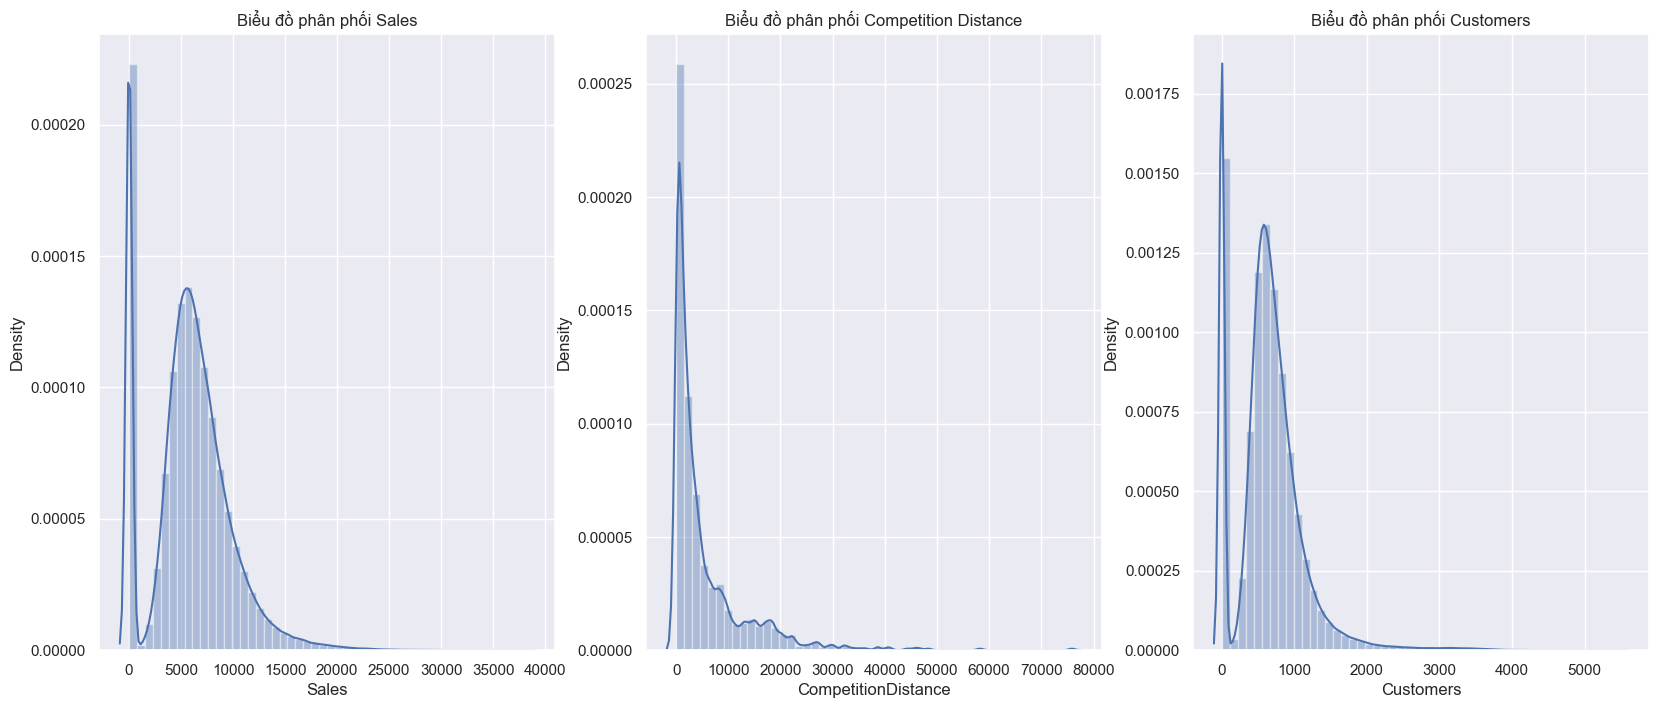

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1,3,1)
sns.distplot(first_data['Sales'])
plt.title('Biểu đồ phân phối Sales');

plt.subplot(1,3,2)
sns.distplot(first_data['CompetitionDistance'])
plt.title('Biểu đồ phân phối Competition Distance');

plt.subplot(1,3,3)
sns.distplot(first_data['Customers'])
plt.title('Biểu đồ phân phối Customers');

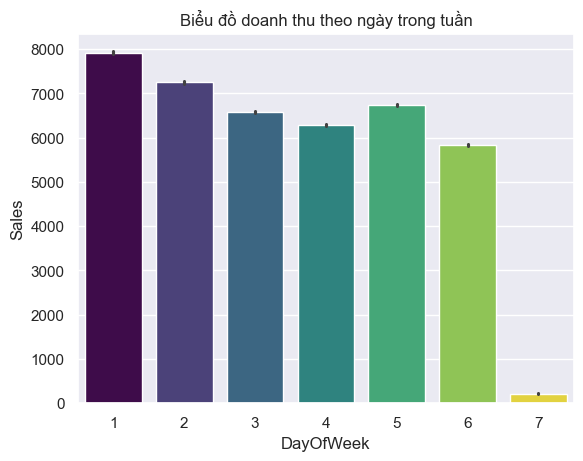

In [ ]:
sns.barplot(data = first_data, x = 'DayOfWeek', y = 'Sales', palette = 'viridis', hue = 'DayOfWeek', legend = False).set(title='Biểu đồ doanh thu theo ngày trong tuần');

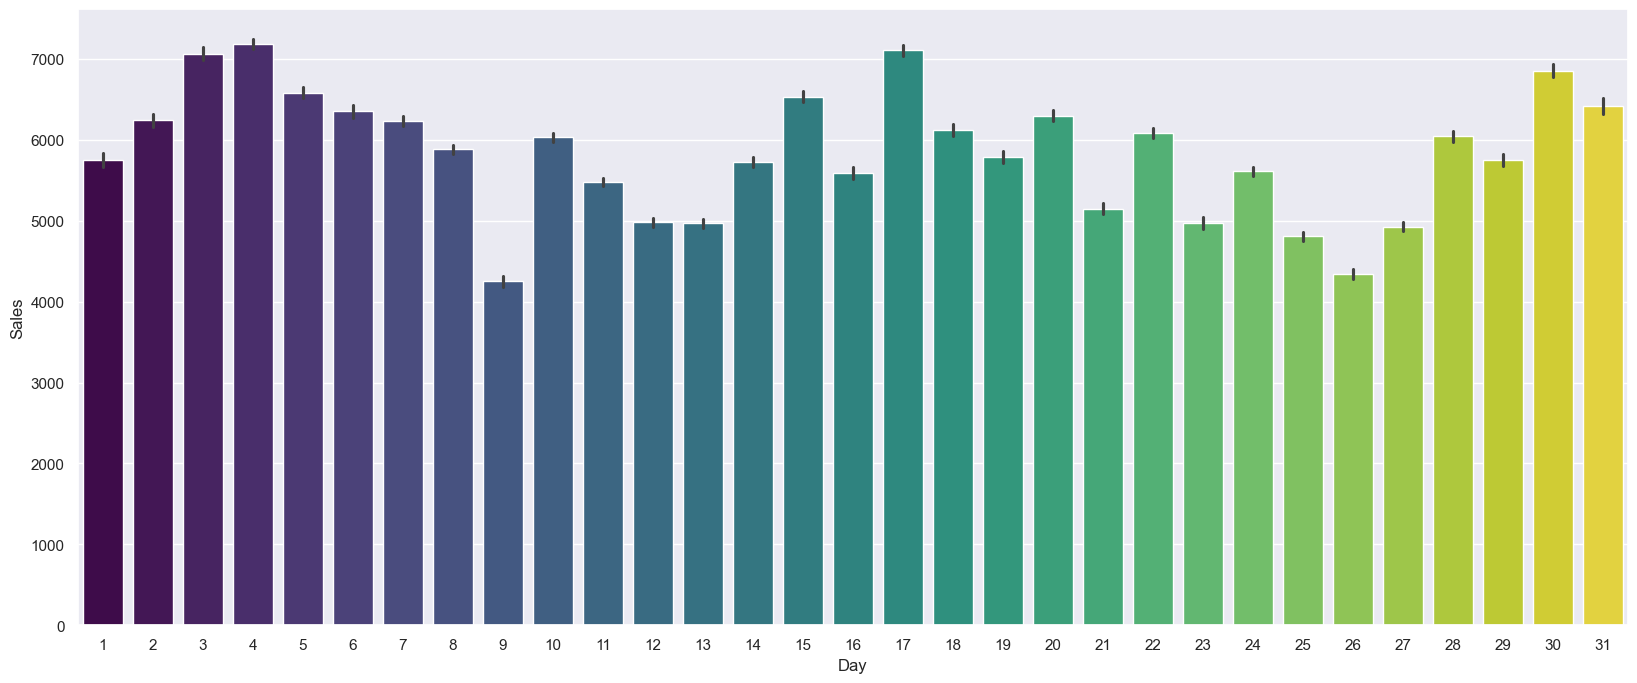

In [ ]:
first_data['Day'] = first_data['Date'].dt.day
data_day = first_data[['Day', 'Sales']].groupby('Day').sum().reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(data = first_data, x = 'Day', y = 'Sales', hue = 'Day', palette = 'viridis', legend = False);

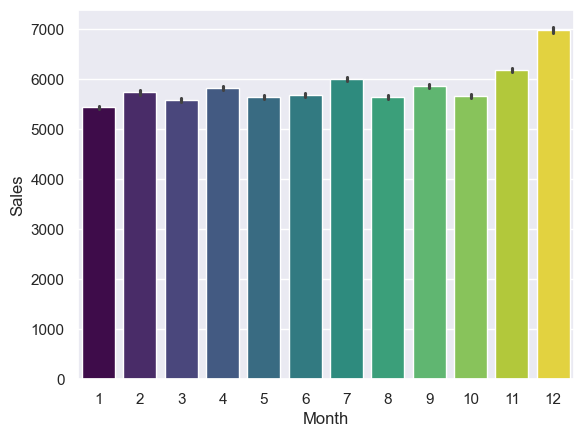

In [ ]:
first_data['Month'] = first_data['Date'].dt.month
sns.barplot(data = first_data, x = 'Month', y = 'Sales', hue = 'Month', palette = 'viridis', legend = False);

In [ ]:
line_data = pd.pivot_table(first_data, index = 'Month', columns = 'StoreType', values = 'Sales', observed = False)
line_data.columns = ['a', 'b', 'c', 'd']
line_data.head()

,a,b,c,d
Month,,,,
1,5401.431197,9408.425047,5335.615083,5331.223211
2,5701.070301,9958.539916,5646.799469,5612.359811
3,5550.226717,9831.172676,5437.254795,5498.180386
4,5778.743023,10408.949020,5705.355180,5703.116571
5,5551.810524,10541.174573,5563.590453,5562.144698


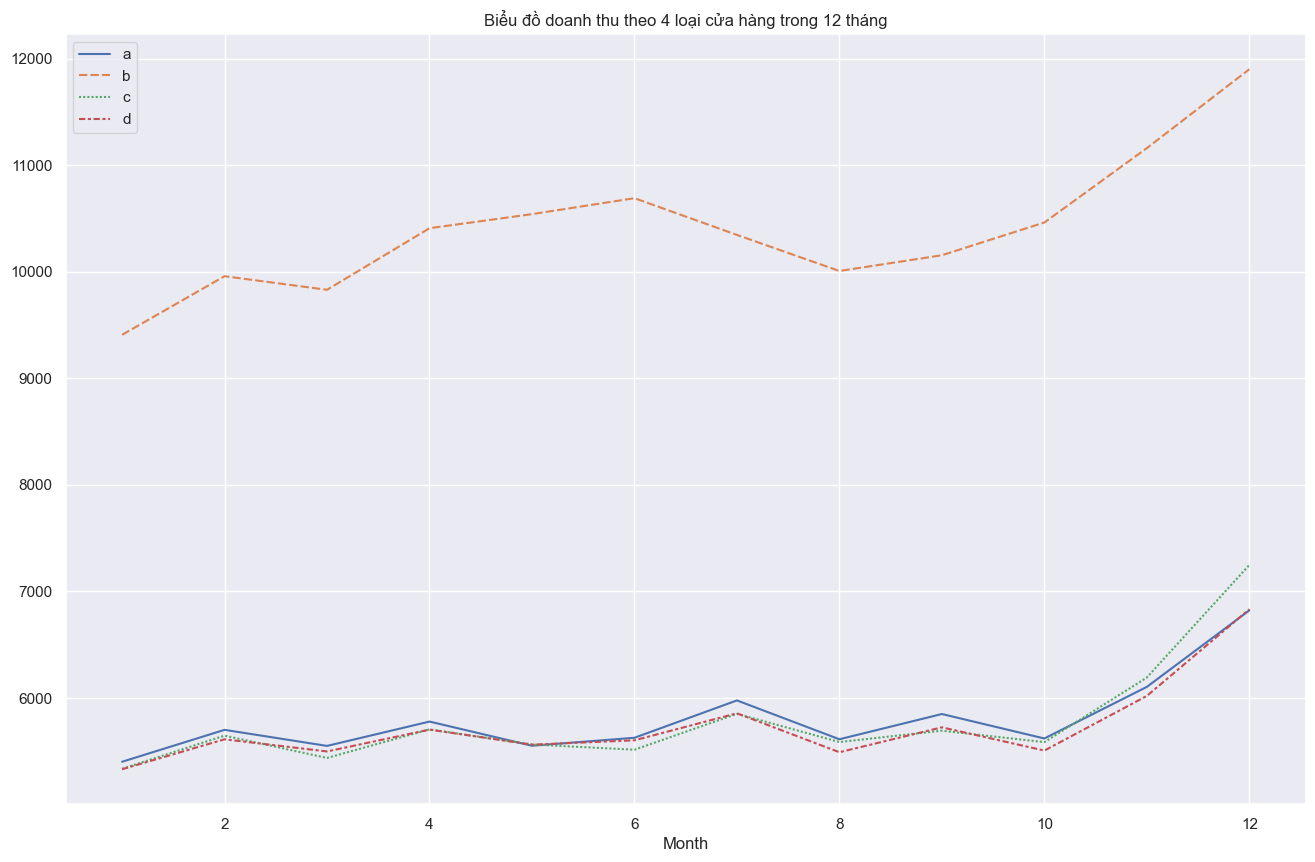

In [ ]:
plt.figure(figsize=(16, 10))
sns.lineplot(data = line_data).set(title='Biểu đồ doanh thu theo 4 loại cửa hàng trong 12 tháng');
plt.show()

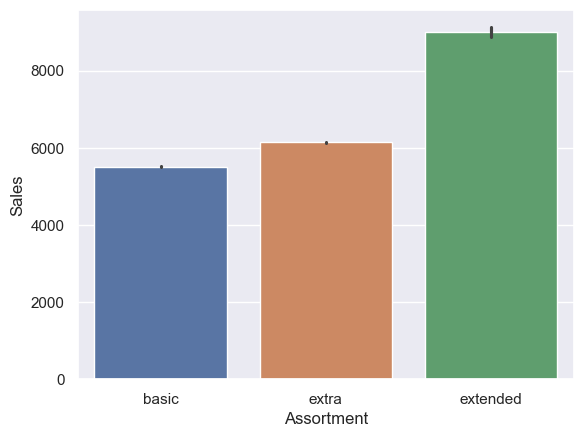

In [ ]:
sns.barplot(data=first_data, x="Assortment", y="Sales", hue="Assortment", legend = False)
plt.xticks(ticks=[0, 1, 2], labels=["basic", "extra", "extended"])
plt.show()

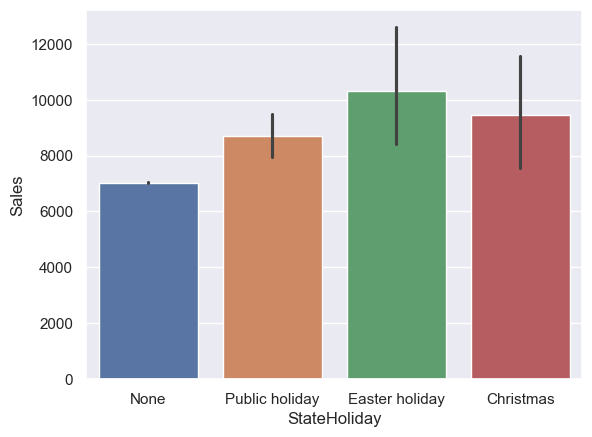

In [ ]:
data_SH = first_data[first_data['Sales'] > 0]
sns.barplot(data=data_SH, x="StateHoliday", y="Sales", hue="StateHoliday", legend = False)
plt.xticks(ticks=[0, 1, 2, 3], labels=["None", "Public holiday", "Easter holiday", "Christmas"])
plt.show()

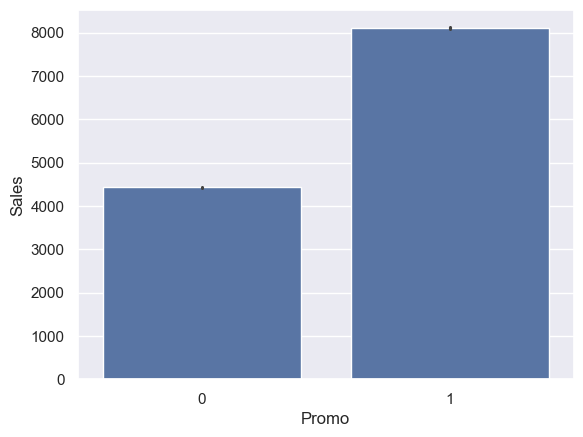

In [ ]:
sns.barplot(data = first_data, x = 'Promo', y = 'Sales');

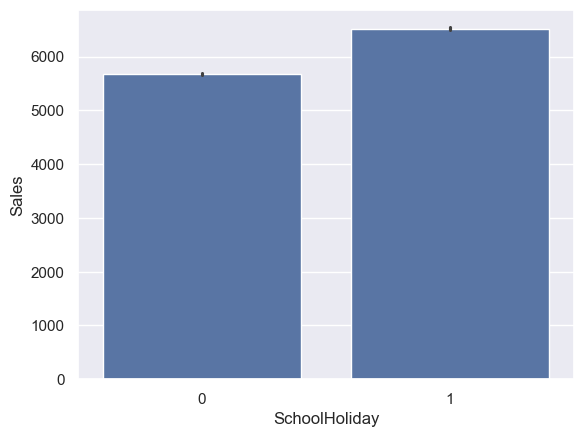

In [ ]:
sns.barplot(data = first_data, x = 'SchoolHoliday', y = 'Sales');

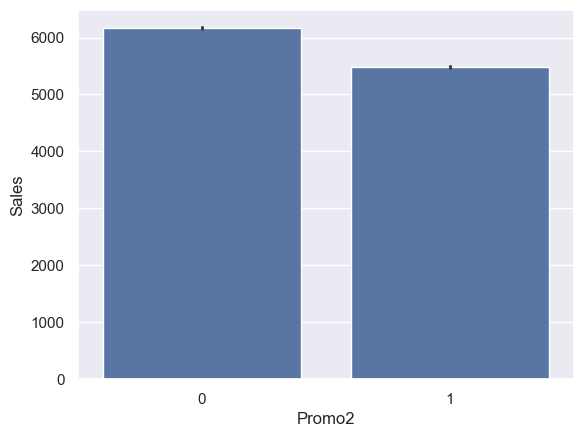

In [ ]:
sns.barplot(data = first_data, x = 'Promo2', y = 'Sales');

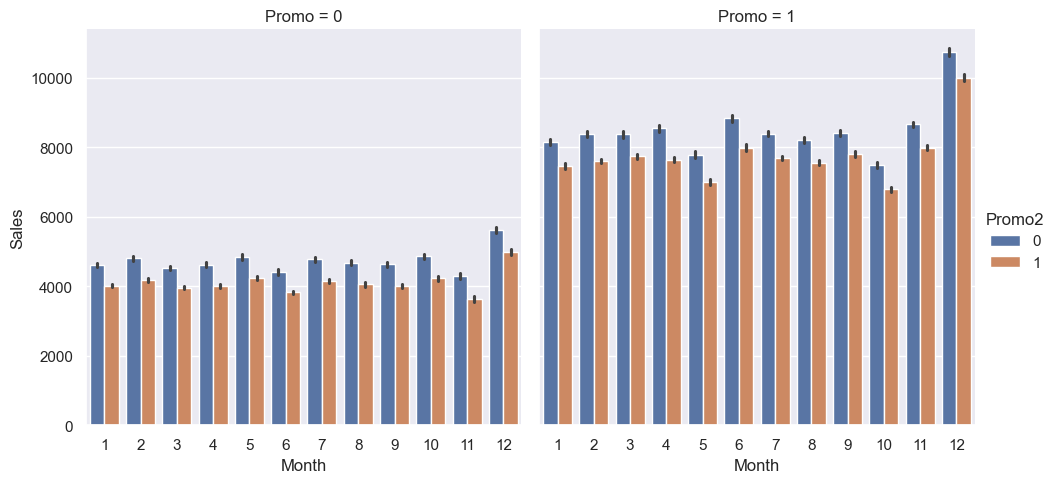

In [ ]:
sns.catplot(data = first_data, x = "Month", y = "Sales", col='Promo', hue = 'Promo2', kind='bar');

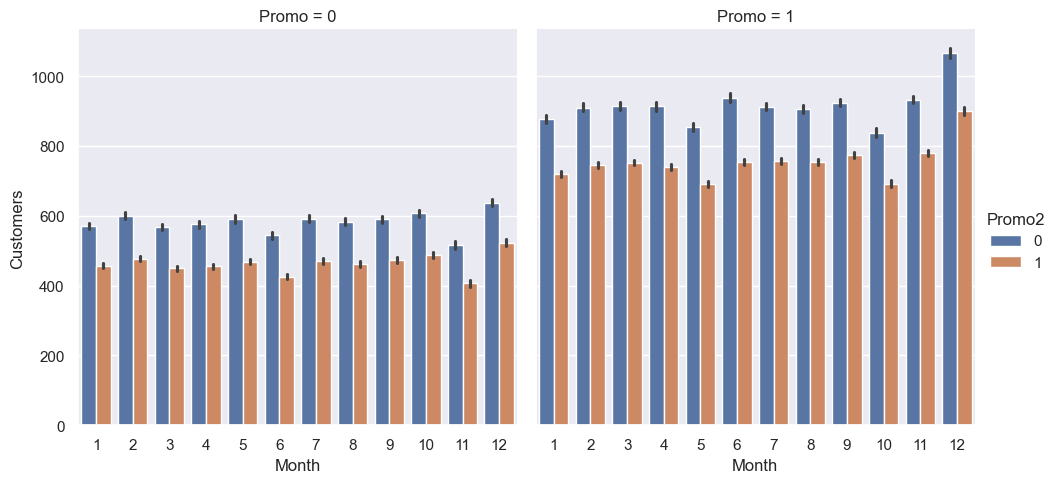

In [ ]:
sns.catplot(data = first_data, x = "Month", y = "Customers", col = 'Promo', hue = 'Promo2', kind = 'bar');

# 3. Tiền xử lý dữ liệu

## 3.1 Filling missing data và loại bỏ outliers

In [ ]:
first_data.isna().sum()

Store                             0
StoreType                         0
Assortment                        0
CompetitionDistance             911
CompetitionOpenSinceMonth    119090
CompetitionOpenSinceYear     119090
Promo2                            0
Promo2SinceWeek              194144
Promo2SinceYear              194144
PromoInterval                194144
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Day                               0
Month                             0
dtype: int64

In [ ]:
first_data['CompetitionDistance'].describe()

count    372944.000000
mean       5473.399465
std        7809.850736
min          20.000000
25%         700.000000
50%        2330.000000
75%        6890.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

In [ ]:
first_data.update(first_data['CompetitionOpenSinceMonth'].fillna(first_data['Date'].dt.month))
first_data.update(first_data['CompetitionOpenSinceYear'].fillna(first_data['Date'].dt.year))
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2014-12-31,2605,327,1,0,0,1,31,12
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2014-12-30,6466,703,1,0,0,1,30,12
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2014-12-29,6463,700,1,0,0,1,29,12
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2014-12-28,0,0,0,0,0,1,28,12
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,6,2014-12-27,6057,684,1,0,0,1,27,12


In [ ]:
first_data.update(first_data['CompetitionDistance'].fillna(150000))

In [ ]:
first_data.update(first_data['Promo2SinceWeek'].fillna(0))
first_data.update(first_data['Promo2SinceYear'].fillna(0))
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,3,2014-12-31,2605,327,1,0,0,1,31,12
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,2,2014-12-30,6466,703,1,0,0,1,30,12
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,1,2014-12-29,6463,700,1,0,0,1,29,12
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,7,2014-12-28,0,0,0,0,0,1,28,12
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,6,2014-12-27,6057,684,1,0,0,1,27,12


In [ ]:
first_data = first_data.copy()
first_data['MonthForPro2'] = first_data['Date'].dt.strftime('%b')
first_data['IsPromo2'] = first_data[['PromoInterval', 'MonthForPro2']].apply(lambda x: x['MonthForPro2'] in str(x['PromoInterval']).split(','), axis = 1).astype('int64')
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,MonthForPro2,IsPromo2
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,3,2014-12-31,2605,327,1,0,0,1,31,12,Dec,0
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,2,2014-12-30,6466,703,1,0,0,1,30,12,Dec,0
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,1,2014-12-29,6463,700,1,0,0,1,29,12,Dec,0
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,7,2014-12-28,0,0,0,0,0,1,28,12,Dec,0
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN,6,2014-12-27,6057,684,1,0,0,1,27,12,Dec,0


In [ ]:
first_data.isna().sum()

Store                             0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                194144
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Day                               0
Month                             0
MonthForPro2                      0
IsPromo2                          0
dtype: int64

In [ ]:
first_data = first_data[(first_data['Open'] != 0) & (first_data['Sales'] > 0)]
first_data.drop('Open', axis = 1, inplace = True)

Số lượng record outliers:  4908


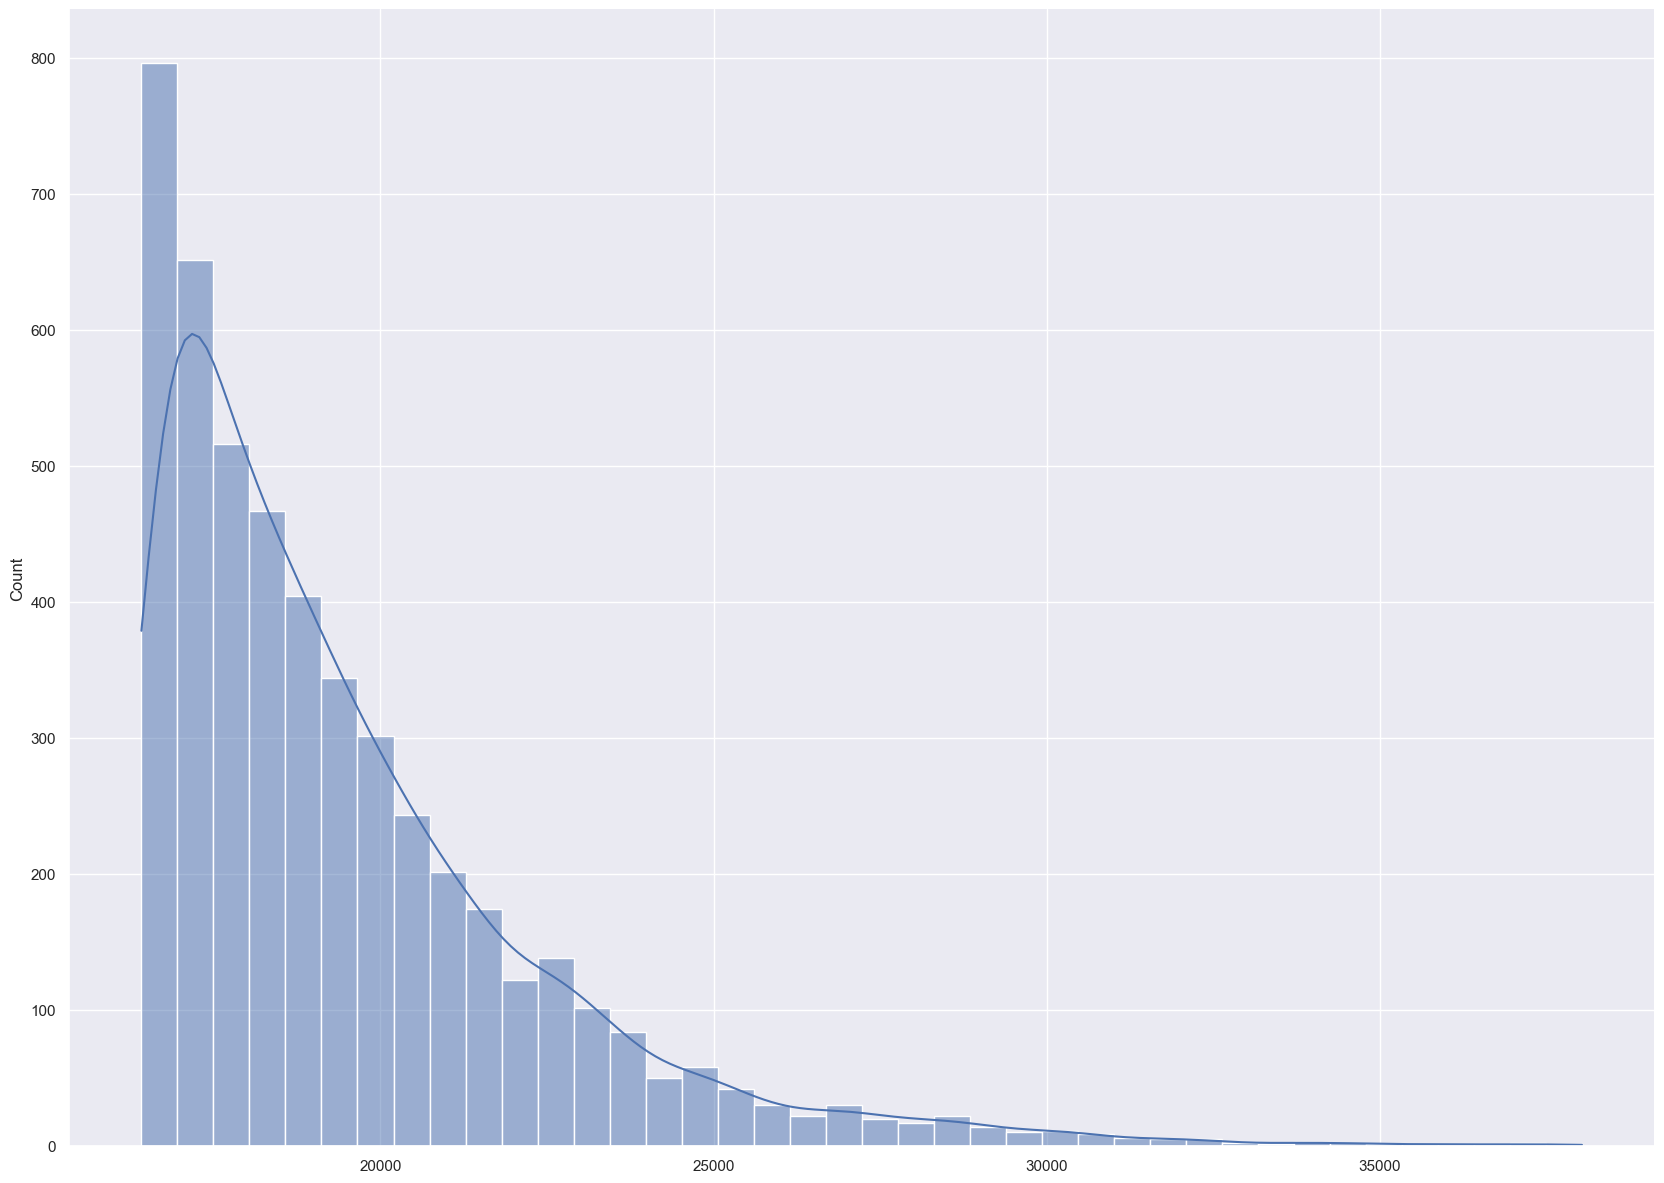

In [ ]:
mean_sales = first_data['Sales'].mean()
std_sales = first_data['Sales'].std()
outliers = []
threshold = 3
for i in first_data['Sales']:
    z_score = (i - mean_sales) / std_sales
    if (z_score > threshold):
        outliers.append(i)
print('Số lượng record outliers: ', len(outliers))
sns.displot(x = outliers, bins = 40, kde = True, height = 12, aspect = 1.4);

In [ ]:
sales_than_25k = first_data[first_data['Sales'] > 25000]
print('Phần trăm giá trị Sales > 25000 trong tập dữ liệu: %.3f%% ' %((len(sales_than_25k)/len(first_data))*100))

Phần trăm giá trị Sales > 25000 trong tập dữ liệu: 0.084% 


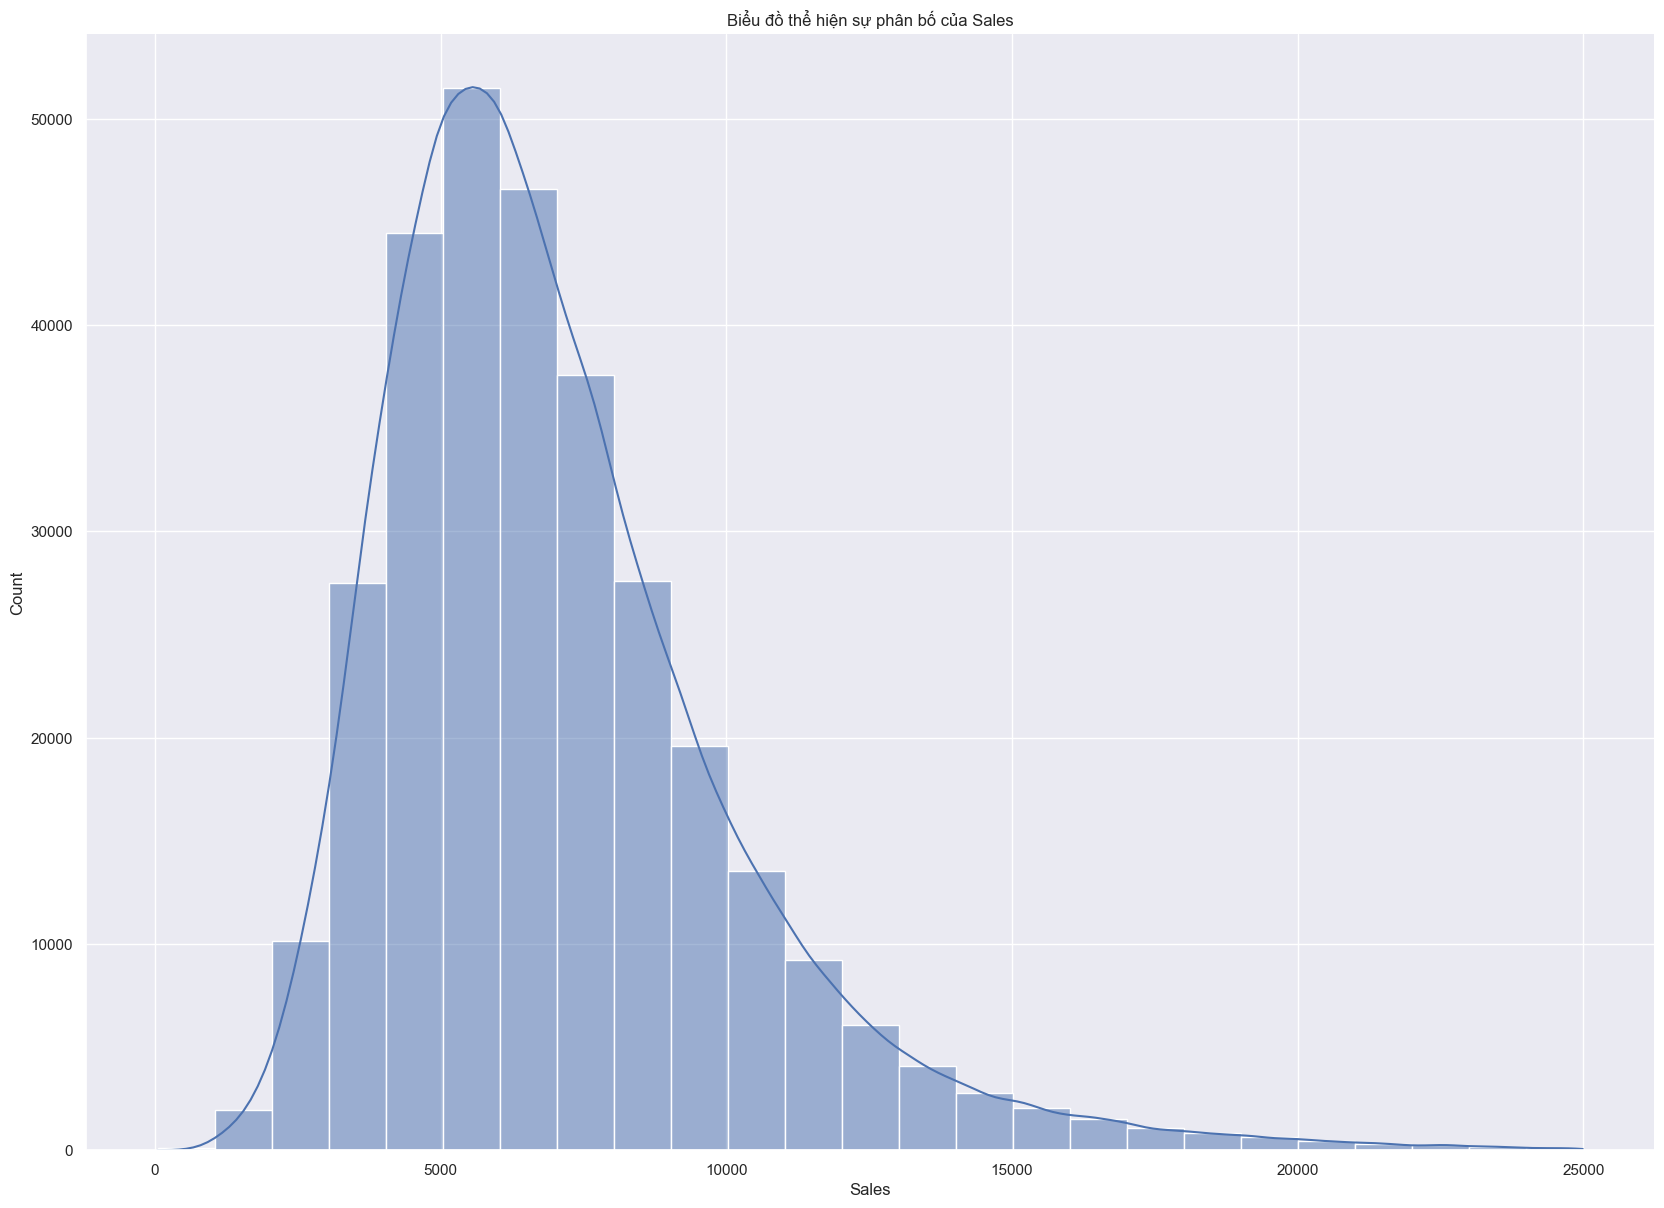

In [ ]:
first_data.drop(first_data.loc[first_data['Sales'] > 25000].index,inplace=True)
sns.displot(first_data,x='Sales', kde = True, bins=25, height = 12, aspect = 1.4).set(title='Biểu đồ thể hiện sự phân bố của Sales');

## 3.2 Định dạng lại kiểu dữ liệu

In [ ]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310124 entries, 0 to 373853
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      310124 non-null  int64         
 1   StoreType                  310124 non-null  object        
 2   Assortment                 310124 non-null  object        
 3   CompetitionDistance        310124 non-null  float64       
 4   CompetitionOpenSinceMonth  310124 non-null  float64       
 5   CompetitionOpenSinceYear   310124 non-null  float64       
 6   Promo2                     310124 non-null  int64         
 7   Promo2SinceWeek            310124 non-null  float64       
 8   Promo2SinceYear            310124 non-null  float64       
 9   PromoInterval              148474 non-null  object        
 10  DayOfWeek                  310124 non-null  int64         
 11  Date                       310124 non-null  datetime64[ns

In [ ]:
first_data['CompetitionOpenSinceMonth'] = first_data['CompetitionOpenSinceMonth'].astype('int64')
first_data['CompetitionOpenSinceYear'] = first_data['CompetitionOpenSinceYear'].astype('int64')
first_data['Promo2SinceWeek'] = first_data['Promo2SinceWeek'].astype('int64')
first_data['Promo2SinceYear'] = first_data['Promo2SinceYear'].astype('int64')
first_data['StoreType'] = first_data['StoreType'].astype('category')
first_data['Assortment'] = first_data['Assortment'].astype('category')
first_data['StateHoliday'] = first_data['StateHoliday'].astype('category')
first_data['CompetitionDistance'] = first_data['CompetitionDistance'].astype('int64')

In [ ]:
first_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310124 entries, 0 to 373853
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      310124 non-null  int64         
 1   StoreType                  310124 non-null  category      
 2   Assortment                 310124 non-null  category      
 3   CompetitionDistance        310124 non-null  int64         
 4   CompetitionOpenSinceMonth  310124 non-null  int64         
 5   CompetitionOpenSinceYear   310124 non-null  int64         
 6   Promo2                     310124 non-null  int64         
 7   Promo2SinceWeek            310124 non-null  int64         
 8   Promo2SinceYear            310124 non-null  int64         
 9   PromoInterval              148474 non-null  object        
 10  DayOfWeek                  310124 non-null  int64         
 11  Date                       310124 non-null  datetime64[ns

## 3.3 Mã hóa dữ liệu phân loại

In [ ]:
label_encoder = LabelEncoder()
first_data['Assortment'] = label_encoder.fit_transform(first_data['Assortment'])
first_data['StoreType'] = label_encoder.fit_transform(first_data['StoreType'])
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,MonthForPro2,IsPromo2
0,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-31,2605,327,0,0,1,31,12,Dec,0
1,1,2,0,1270,9,2008,0,0,0,NaN,2,2014-12-30,6466,703,0,0,1,30,12,Dec,0
2,1,2,0,1270,9,2008,0,0,0,NaN,1,2014-12-29,6463,700,0,0,1,29,12,Dec,0
4,1,2,0,1270,9,2008,0,0,0,NaN,6,2014-12-27,6057,684,0,0,1,27,12,Dec,0
7,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-24,3659,421,0,0,1,24,12,Dec,0


In [ ]:
dummies_data = pd.get_dummies(first_data['StateHoliday'], prefix = 'StateHoliday', dtype = np.int64)
dummies_data = dummies_data.rename(columns = {'StateHoliday_a': 'PublicHoliday', 'StateHoliday_b': 'EasterHoliday', 'StateHoliday_c': 'Christmas'})
first_data = pd.concat([first_data, dummies_data], axis=1)
first_data.drop(columns = ['StateHoliday_0'], inplace = True)
first_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,MonthForPro2,IsPromo2,PublicHoliday,EasterHoliday,Christmas
0,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-31,2605,327,0,0,1,31,12,Dec,0,0,0,0
1,1,2,0,1270,9,2008,0,0,0,NaN,2,2014-12-30,6466,703,0,0,1,30,12,Dec,0,0,0,0
2,1,2,0,1270,9,2008,0,0,0,NaN,1,2014-12-29,6463,700,0,0,1,29,12,Dec,0,0,0,0
4,1,2,0,1270,9,2008,0,0,0,NaN,6,2014-12-27,6057,684,0,0,1,27,12,Dec,0,0,0,0
7,1,2,0,1270,9,2008,0,0,0,NaN,3,2014-12-24,3659,421,0,0,1,24,12,Dec,0,0,0,0


## 3.4 Chuẩn hóa dữ liệu

### 3.4.1 Lựa chọn phương pháp chuẩn hóa

In [ ]:
train_data = first_data.copy()

In [ ]:
train_data[['CompetitionDistance', 'Promo2SinceWeek',
       'Promo2SinceYear', 'DayOfWeek', 'Day', 'Month', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].describe().T

,count,mean,std,min,25%,50%,75%,max
CompetitionDistance,310124.0,5854.057700,10628.259288,20.0,700.0,2340.0,6910.0,150000.0
Promo2SinceWeek,310124.0,10.842627,14.901088,0.0,0.0,0.0,18.0,50.0
Promo2SinceYear,310124.0,963.131605,1004.961124,0.0,0.0,0.0,2012.0,2015.0
DayOfWeek,310124.0,3.513033,1.722256,1.0,2.0,3.0,5.0,7.0
Day,310124.0,15.744992,8.719486,1.0,8.0,16.0,23.0,31.0
Month,310124.0,6.258106,3.439545,1.0,3.0,6.0,9.0,12.0
CompetitionOpenSinceYear,310124.0,2010.412754,5.244407,1900.0,2008.0,2012.0,2014.0,2015.0
CompetitionOpenSinceMonth,310124.0,6.917601,3.317236,1.0,4.0,7.0,10.0,12.0


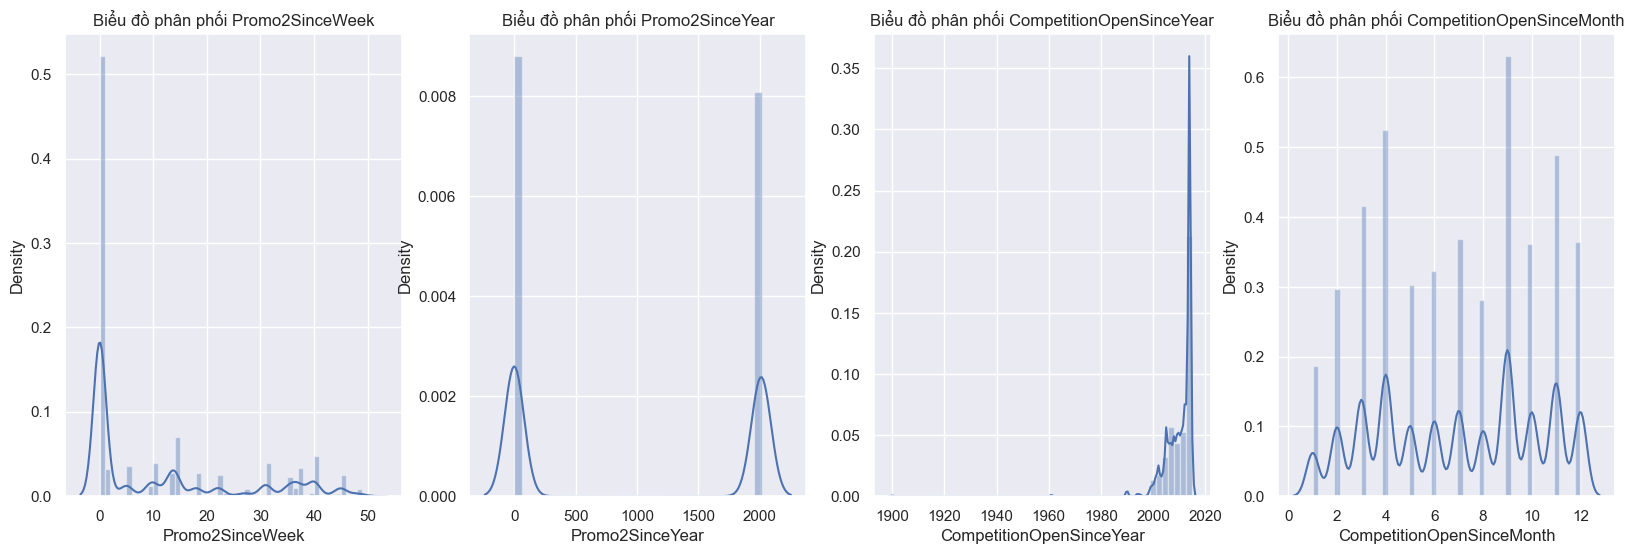

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1,4,1)
sns.distplot(first_data['Promo2SinceWeek'])
plt.title('Biểu đồ phân phối Promo2SinceWeek');

plt.subplot(1,4,2)
sns.distplot(first_data['Promo2SinceYear'])
plt.title('Biểu đồ phân phối Promo2SinceYear');

plt.subplot(1,4,3)
sns.distplot(first_data['CompetitionOpenSinceYear'])
plt.title('Biểu đồ phân phối CompetitionOpenSinceYear');

plt.subplot(1,4,4)
sns.distplot(first_data['CompetitionOpenSinceMonth'])
plt.title('Biểu đồ phân phối CompetitionOpenSinceMonth');

In [ ]:
mean_PW = first_data['Promo2SinceWeek'].mean()
std_PW = first_data['Promo2SinceWeek'].std()
outliers_PW = []
threshold = 3
for i in first_data['Promo2SinceWeek']:
    z_score = (i - mean_PW) / std_PW
    if (z_score > threshold):
        outliers_PW.append(i)
print('Số lượng record outliers: ', len(outliers_PW))

Số lượng record outliers:  0


In [ ]:
mean_PY = first_data['Promo2SinceYear'].mean()
std_PY = first_data['Promo2SinceYear'].std()
outliers_PY = []
threshold = 3
for i in first_data['Promo2SinceYear']:
    z_score = (i - mean_PY) / std_PY
    if (z_score > threshold):
        outliers_PY.append(i)
print('Số lượng record outliers: ', len(outliers_PY))

Số lượng record outliers:  0


In [ ]:
mean_COSM = first_data['CompetitionOpenSinceMonth'].mean()
std_COSM = first_data['CompetitionOpenSinceMonth'].std()
outliers_COSM = []
threshold = 3
for i in first_data['CompetitionOpenSinceMonth']:
    z_score = (i - mean_COSM) / std_COSM
    if (z_score > threshold):
        outliers_COSM.append(i)
print('Số lượng record outliers: ', len(outliers_COSM))

Số lượng record outliers:  0


In [ ]:
mean_COSY = first_data['CompetitionOpenSinceYear'].mean()
std_COSY = first_data['CompetitionOpenSinceYear'].std()
outliers_COSY = []
threshold = 3
for i in first_data['CompetitionOpenSinceYear']:
    z_score = (i - mean_COSY) / std_COSY
    if (z_score > threshold):
        outliers_COSY.append(i)
print('Số lượng record outliers: ', len(outliers_COSY))

Số lượng record outliers:  0


### 3.4.2 Chuẩn hóa dữu liệu

In [ ]:
rb = RobustScaler()
ms = MinMaxScaler()

In [ ]:
train_data[['CompetitionDistance', 'Promo2SinceWeek',
       'Promo2SinceYear', 'DayOfWeek', 'Day', 'Month', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].describe().T

,count,mean,std,min,25%,50%,75%,max
CompetitionDistance,310124.0,5854.057700,10628.259288,20.0,700.0,2340.0,6910.0,150000.0
Promo2SinceWeek,310124.0,10.842627,14.901088,0.0,0.0,0.0,18.0,50.0
Promo2SinceYear,310124.0,963.131605,1004.961124,0.0,0.0,0.0,2012.0,2015.0
DayOfWeek,310124.0,3.513033,1.722256,1.0,2.0,3.0,5.0,7.0
Day,310124.0,15.744992,8.719486,1.0,8.0,16.0,23.0,31.0
Month,310124.0,6.258106,3.439545,1.0,3.0,6.0,9.0,12.0
CompetitionOpenSinceYear,310124.0,2010.412754,5.244407,1900.0,2008.0,2012.0,2014.0,2015.0
CompetitionOpenSinceMonth,310124.0,6.917601,3.317236,1.0,4.0,7.0,10.0,12.0


In [ ]:
train_data['CompetitionDistance'] = rb.fit_transform(train_data[['CompetitionDistance']])
train_data['CompetitionDistance'].describe().T

count    310124.000000
mean          0.565871
std           1.711475
min          -0.373591
25%          -0.264090
50%           0.000000
75%           0.735910
max          23.777778
Name: CompetitionDistance, dtype: float64

In [ ]:
train_data['CompetitionOpenSinceMonth'] = ms.fit_transform(train_data[['CompetitionOpenSinceMonth']])
train_data['CompetitionOpenSinceYear'] = ms.fit_transform(train_data[['CompetitionOpenSinceYear']])
train_data['Promo2SinceWeek'] = ms.fit_transform(train_data[['Promo2SinceWeek']])
train_data['Promo2SinceYear'] = ms.fit_transform(train_data[['Promo2SinceYear']])
train_data[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']].describe().T

,count,mean,std,min,25%,50%,75%,max
CompetitionOpenSinceMonth,310124.0,0.537964,0.301567,0.0,0.272727,0.545455,0.818182,1.0
CompetitionOpenSinceYear,310124.0,0.960111,0.045604,0.0,0.939130,0.973913,0.991304,1.0
Promo2SinceWeek,310124.0,0.216853,0.298022,0.0,0.000000,0.000000,0.360000,1.0
Promo2SinceYear,310124.0,0.477981,0.498740,0.0,0.000000,0.000000,0.998511,1.0


In [ ]:
train_data['DayOfWeekSin'] = train_data['DayOfWeek'].apply(lambda x : np.sin(x * (2 * np.pi/7)))
train_data['DayOfWeekCos'] = train_data['DayOfWeek'].apply(lambda x : np.cos(x * (2 * np.pi/7)))
train_data['DaySin'] = train_data['Day'].apply(lambda x : np.sin(x * (2 * np.pi/31)))
train_data['DayCos'] = train_data['Day'].apply(lambda x : np.cos(x * (2 * np.pi/31)))
train_data['MonthSin'] = train_data['Month'].apply(lambda x : np.sin(x * (2 * np.pi/12)))
train_data['MonthCos'] = train_data['Month'].apply(lambda x : np.cos(x * (2 * np.pi/12)))
train_data[['DayOfWeekSin', 'DayOfWeekCos', 'DaySin', 'DayCos', 'MonthSin', 'MonthCos']].describe().T

,count,mean,std,min,25%,50%,75%,max
DayOfWeekSin,310124.0,0.008465,0.762719,-0.974928,-0.781831,4.338837e-01,0.781831,0.974928
DayOfWeekCos,310124.0,-0.159125,0.626793,-0.900969,-0.900969,-2.225209e-01,0.623490,1.000000
DaySin,310124.0,0.007464,0.715547,-0.998717,-0.724793,-2.449294e-16,0.724793,0.998717
DayCos,310124.0,-0.029974,0.697884,-0.994869,-0.758758,-5.064917e-02,0.688967,1.000000
MonthSin,310124.0,0.042684,0.708632,-1.000000,-0.500000,1.224647e-16,0.866025,1.000000
MonthCos,310124.0,-0.013572,0.704158,-1.000000,-0.866025,6.123234e-17,0.500000,1.000000


## 3.5 Lựa chọn đặc trưng

In [ ]:
train_data.set_index('Date', inplace=True)

In [ ]:
train_data.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Sales', 'Customers', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Day',
       'Month', 'MonthForPro2', 'IsPromo2', 'PublicHoliday', 'EasterHoliday',
       'Christmas', 'DayOfWeekSin', 'DayOfWeekCos', 'DaySin', 'DayCos',
       'MonthSin', 'MonthCos'],
      dtype='object')

In [ ]:
col_drop = ['PromoInterval', 'MonthForPro2', 'Customers', 'DayOfWeek', 'Day', 'Month', 'StateHoliday']
train_data.drop(columns = col_drop, axis = 1, inplace = True)

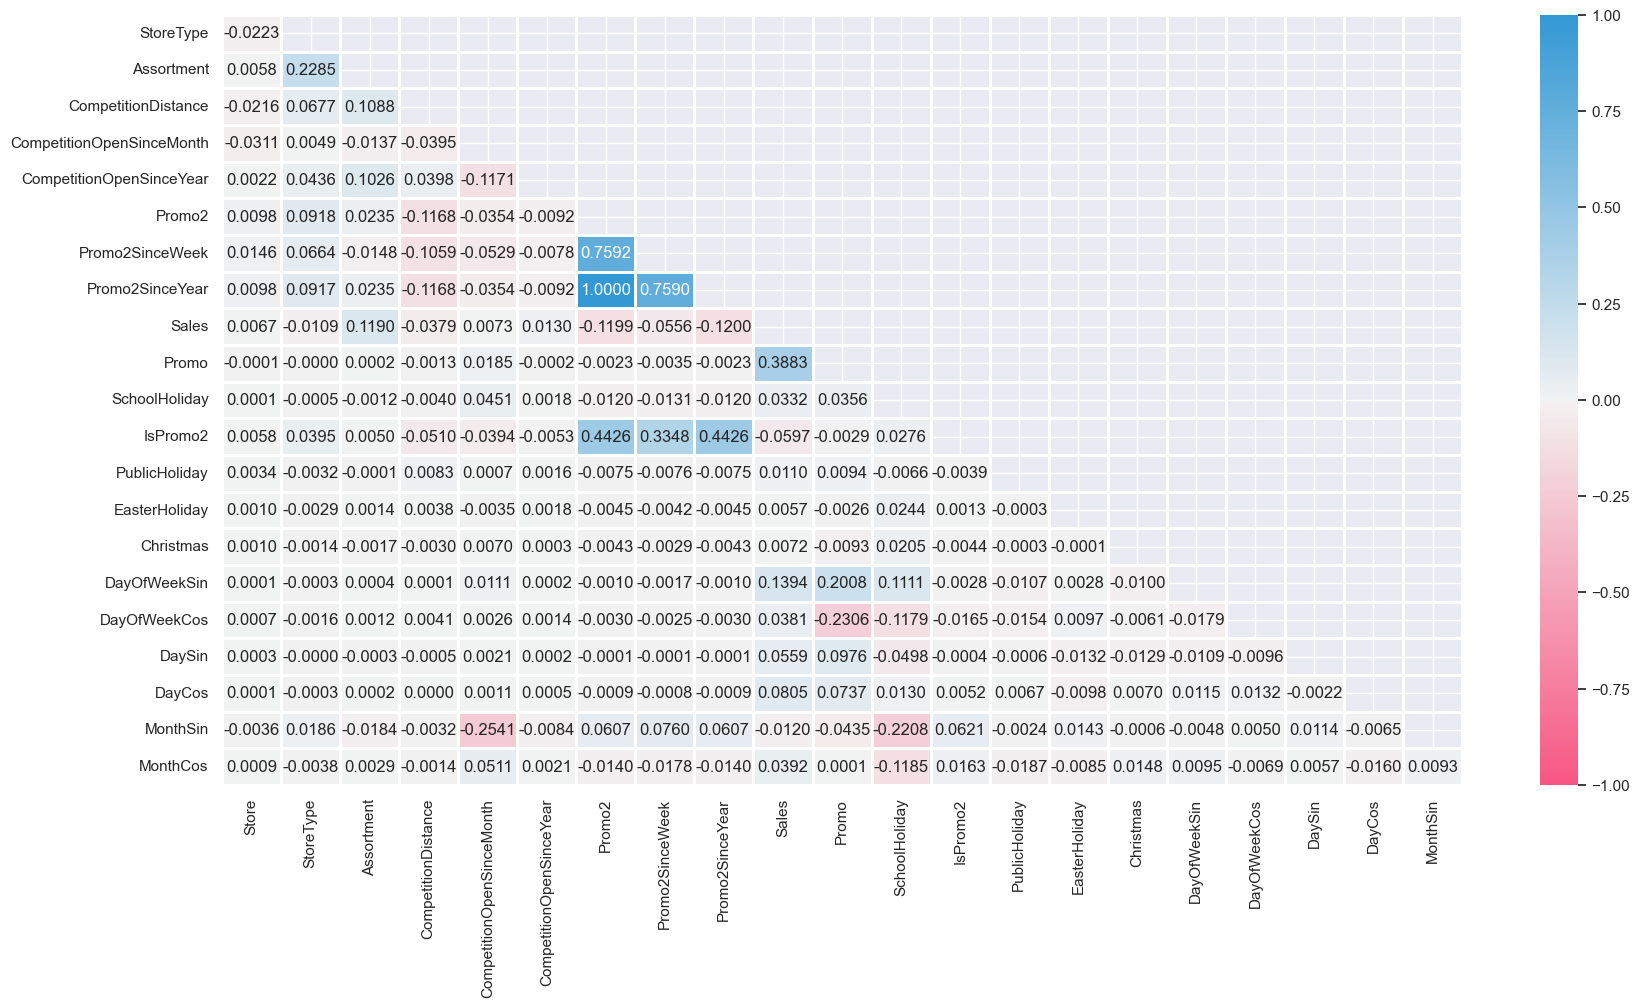

In [ ]:
corr_data = train_data.corr()
corr_one = np.ones_like(corr_data, dtype = bool)
one_mask = np.triu(corr_one)
corr_data = corr_data.iloc[1:,:-1]
one_mask = one_mask[1:,:-1]

fig, ax = plt.subplots(figsize = (20, 10))
cmap = sns.diverging_palette(0, 239, 90, 60, as_cmap = True)
# 'BrBG'
sns.heatmap(data = corr_data, mask = one_mask, annot = True, fmt = '.4f', cmap = cmap, vmin = -1, vmax = 1, linecolor = 'white', linewidths = 1);

- Sử dụng Boruta để lựa chọn features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_data.drop(['Sales'],axis = 1), train_data['Sales'], test_size = 0.2, random_state = 42)

In [ ]:
x_boruta = x_train.values
y_boruta = y_train.values
reg = RandomForestRegressor(random_state=42)
boruta = BorutaPy(reg, n_estimators='auto', verbose=2, random_state=42)
np.int = np.int32
np.float = np.float64
np.bool = np.bool_
boruta.fit(x_boruta, y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	7


BorutaPy(estimator=RandomForestRegressor(n_estimators=64,
                                         random_state=RandomState(MT19937) at 0x2751B3FB240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2751B3FB240, verbose=2)

In [ ]:
cols_selected = boruta.support_.tolist()
x_train_fs = x_train.copy()
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )
print('Features bị Boruta loại bỏ: ', cols_not_selected_boruta)

Features bị Boruta loại bỏ:  ['Christmas', 'EasterHoliday', 'IsPromo2', 'MonthSin', 'Promo2', 'PublicHoliday', 'SchoolHoliday']


# 4. Mô hình Random Forest Regression

## 4.1 Mô hình thô

In [ ]:
reg = RandomForestRegressor(random_state=42)
reg.fit(x_train, y_train)
y_predict = reg.predict(x_test)
R2_train_raw = reg.score(x_train, y_train)
R2_test_raw = r2_score(y_test, y_predict)
MAE_raw = mean_absolute_error(y_test, y_predict)
MSE_raw = mean_squared_error(y_test, y_predict)
print('R2(train): ', R2_train_raw)
print('R2(test): ', R2_test_raw)
print('MAE: ', MAE_raw)
print('MSE: ', MSE_raw)

R2(train):  0.9863354628067308
R2(test):  0.8991896342471865
MAE:  616.6555906489318
MSE:  937688.201720911


## 4.2 Điều chỉnh loại bỏ features theo Boruta

In [ ]:
reg = RandomForestRegressor(random_state=42)
x_train_boruta = x_train.drop(columns = ['Christmas', 'EasterHoliday', 'IsPromo2', 'MonthSin', 'Promo2', 'PublicHoliday', 'SchoolHoliday'], axis = 1)
x_test_boruta = x_test.drop(columns = ['Christmas', 'EasterHoliday', 'IsPromo2', 'MonthSin', 'Promo2', 'PublicHoliday', 'SchoolHoliday'], axis = 1)
reg.fit(x_train_boruta, y_train)
y_predict = reg.predict(x_test_boruta)
R2_train_boruta = reg.score(x_train_boruta, y_train)
R2_test_boruta = r2_score(y_test, y_predict)
MAE_boruta = mean_absolute_error(y_test, y_predict)
MSE_boruta = mean_squared_error(y_test, y_predict)
print('R2(train): ', R2_train_boruta)
print('R2(test): ', R2_test_boruta)
print('MAE: ', MAE_boruta)
print('MSE: ', MSE_boruta)

R2(train):  0.9848976742582338
R2(test):  0.8896770958548078
MAE:  651.8277444578799
MSE:  1026169.1327476068


In [ ]:
reg = RandomForestRegressor(random_state=42)
x_train_test1 = x_train.drop(columns = ['EasterHoliday'], axis = 1)
x_test_test1 = x_test.drop(columns = ['EasterHoliday'], axis = 1)
reg.fit(x_train_test1, y_train)
y_predict = reg.predict(x_test_test1)
R2_train = reg.score(x_train_test1, y_train)
R2_test = r2_score(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
MSE = mean_squared_error(y_test, y_predict)
print('R2(train): ', R2_train)
print('R2(test): ', R2_test)
print('MAE: ', MAE)
print('MSE: ', MSE)

R2(train):  0.9863292940806473
R2(test):  0.8992739864375673
MAE:  616.7160119306732
MSE:  936903.5993328657


In [ ]:
x_train.drop('EasterHoliday', axis = 1, inplace = True)
x_test.drop('EasterHoliday', axis = 1, inplace = True)

In [ ]:
feature_importance = pd.DataFrame(x_train.columns)
feature_importance = pd.concat([feature_importance, pd.Series(reg.feature_importances_)], axis=1)
feature_importance.columns = ['Feature', 'Importance']
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = False)
feature_importance.head(20)

,Feature,Importance
3,CompetitionDistance,0.211878
0,Store,0.182183
9,Promo,0.150217
5,CompetitionOpenSinceYear,0.077632
4,CompetitionOpenSinceMonth,0.056525
15,DayOfWeekCos,0.047690
8,Promo2SinceYear,0.037553
1,StoreType,0.035071
19,MonthCos,0.034764
7,Promo2SinceWeek,0.034673


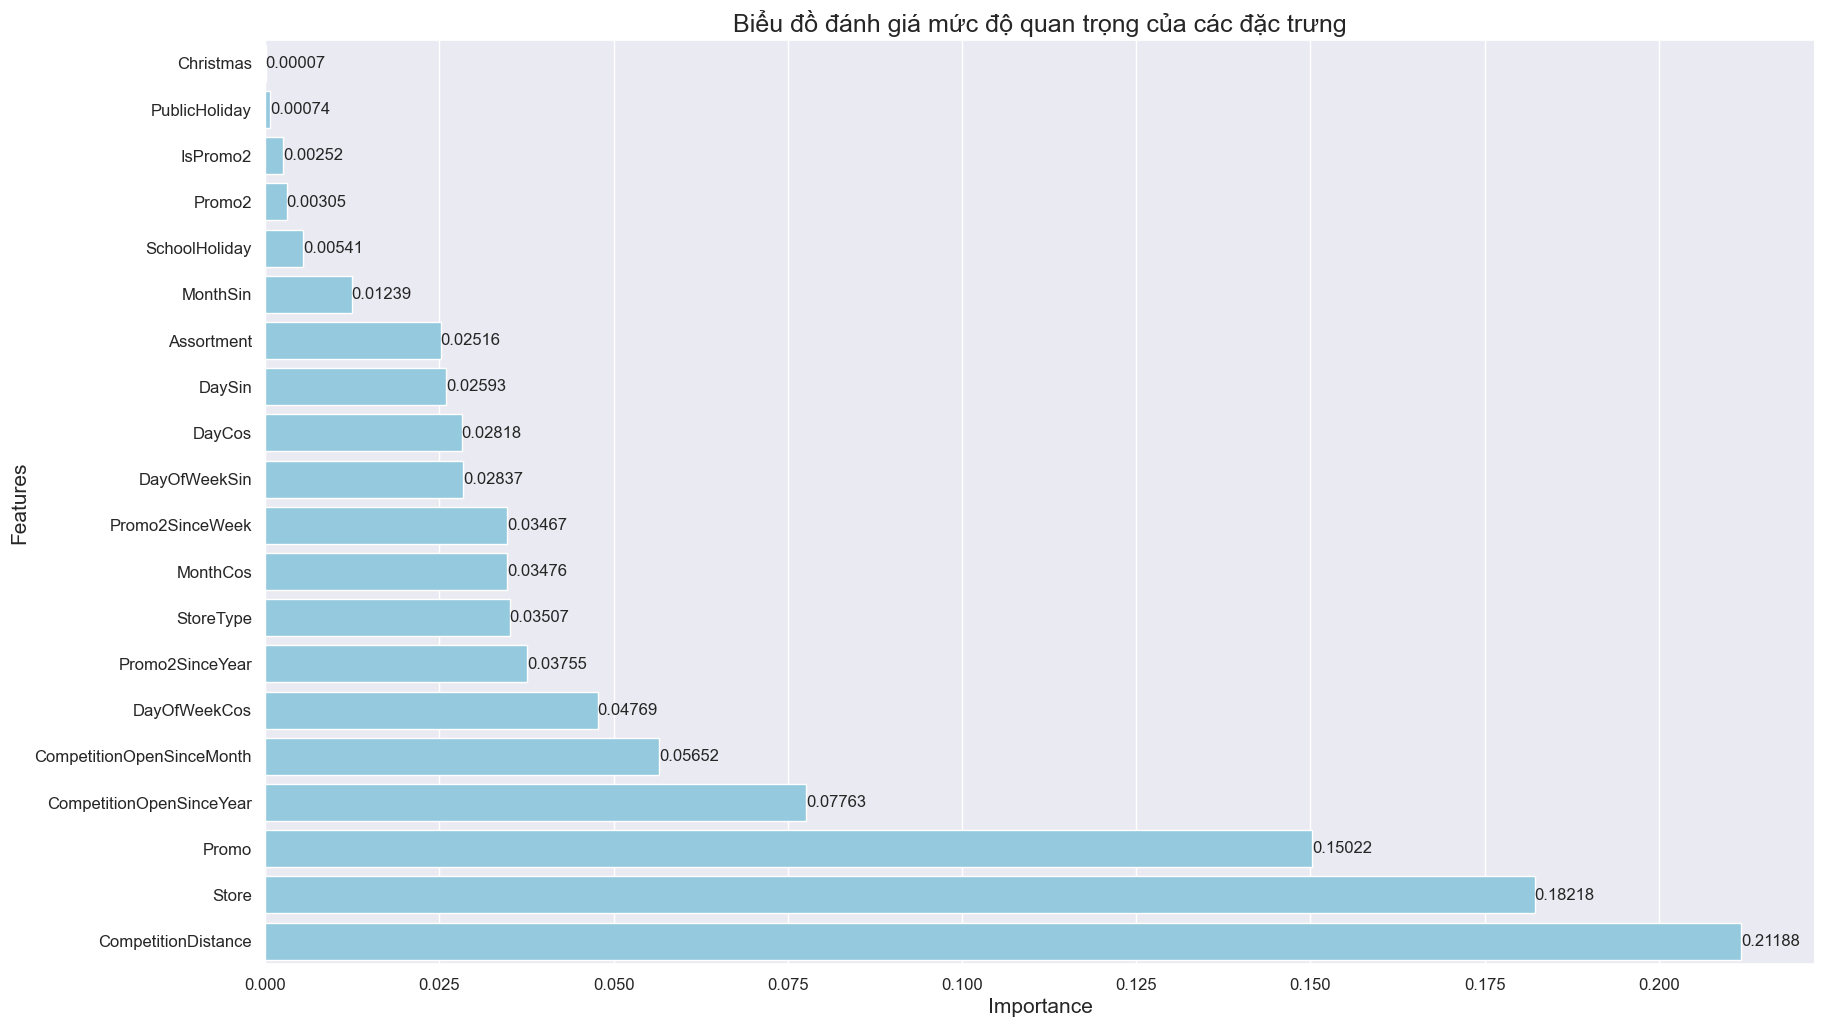

In [ ]:
plt.figure(figsize = (20, 12))
feature_importance = feature_importance.sort_values(by = 'Importance', ascending = True)
sns.barplot(x = feature_importance['Importance'], y = feature_importance['Feature'], color = 'skyblue')
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.5f}', va = 'center', ha = 'left', fontsize=12)
plt.xticks(fontsize = 12)
plt.xlabel('Importance', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Features', fontsize = 15)
plt.title('Biểu đồ đánh giá mức độ quan trọng của các đặc trưng', fontsize = 18);

## 4.3 Mô hình có điều chỉnh thông số

### 4.3.1 Điều chỉnh n_estimators

In [ ]:
ft = ['n_estimators', 'R2_train', 'R2_test', 'MAE', 'MSE']
df_estimators = pd.DataFrame(columns = ft)
estimators = [60, 80, 100, 120, 140]
for i in estimators:
    reg = RandomForestRegressor(n_estimators = i, n_jobs= 7, random_state=42)
    reg.fit(x_train, y_train)
    y_predict = reg.predict(x_test)
    R2_train = reg.score(x_train, y_train)
    R2_test = r2_score(y_test, y_predict)
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    new_record = {'n_estimators': i, 'R2_train': R2_train, 'R2_test': R2_test, 'MAE': MAE, 'MSE': MSE}
    df_estimators.loc[len(df_estimators)] = new_record
df_estimators.head()

,n_estimators,R2_train,R2_test,MAE,MSE
0,60,0.985819,0.898011,620.306608,948649.857686
1,80,0.986140,0.898945,617.898541,939966.180195
2,100,0.986329,0.899274,616.716012,936903.599333
3,120,0.986438,0.899404,616.007250,935698.434336
4,140,0.986502,0.899530,615.380641,934525.654525


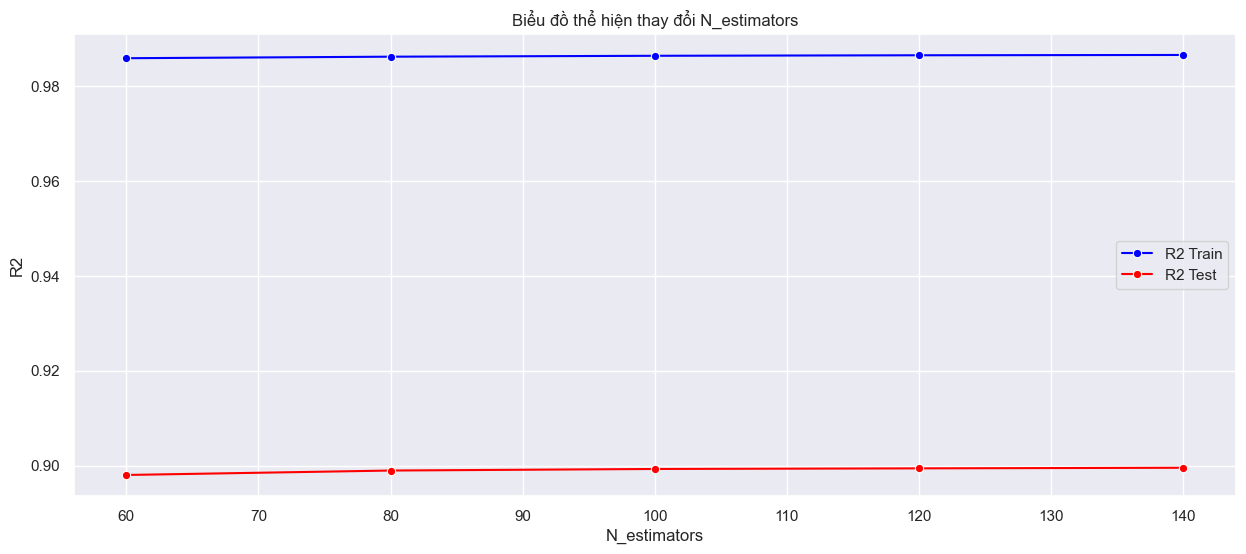

In [ ]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = estimators, y = df_estimators['R2_train'], label = 'R2 Train', marker = 'o', color = 'blue')
sns.lineplot(x = estimators, y = df_estimators['R2_test'], label = 'R2 Test', marker = 'o', color = 'red')
plt.xlabel('N_estimators')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.title('Biểu đồ thể hiện thay đổi N_estimators')
plt.show()

### 4.3.2 Điều chỉnh max_depth, min_samples_split, max_leaf_nodes bằng BayesSearchCV

In [ ]:
param_space = {
    'max_depth': [33, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    }
reg = RandomForestRegressor(n_estimators = 140, random_state=42)
bsc = BayesSearchCV(
    reg,
    param_space,
    n_iter=100,
    cv=3,
    n_jobs=4,
    verbose=2,
    scoring='neg_mean_squared_error'
    #random_state=42
)
bsc.fit(x_train, y_train)
print("Best parameters found: ", bsc.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:  OrderedDict({'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5})


In [ ]:
reg = RandomForestRegressor(n_estimators = 140, max_depth = 36, min_samples_leaf = 1, min_samples_split = 2, random_state=42)
reg.fit(x_train, y_train)
y_predict = reg.predict(x_test)
R2_train_raw = reg.score(x_train, y_train)
R2_test_raw = r2_score(y_test, y_predict)
MAE_raw = mean_absolute_error(y_test, y_predict)
MSE_raw = mean_squared_error(y_test, y_predict)
print('R2(train): ', R2_train_raw)
print('R2(test): ', R2_test_raw)
print('MAE: ', MAE_raw)
print('MSE: ', MSE_raw)

### 4.3.3 Điều chỉnh max_feature

In [ ]:
ft = ['n_features', 'R2_train', 'R2_test', 'MAE', 'MSE']
df_features = pd.DataFrame(columns = ft)
n_features = [7, 9, 10, 11, 13, 15, 17, 18, 20]
for i in n_features:
    reg = RandomForestRegressor(n_estimators = 140, max_depth = 36, min_samples_leaf = 1, min_samples_split = 2, max_features = i, n_jobs= 7, random_state=42)
    reg.fit(x_train, y_train)
    y_predict = reg.predict(x_test)
    R2_train = reg.score(x_train, y_train)
    R2_test = r2_score(y_test, y_predict)
    MAE = mean_absolute_error(y_test, y_predict)
    MSE = mean_squared_error(y_test, y_predict)
    new_record = {'n_features': i, 'R2_train': R2_train, 'R2_test': R2_test, 'MAE': MAE, 'MSE': MSE}
    df_features.loc[len(df_features)] = new_record
df_features.head(10)

,n_features,R2_train,R2_test,MAE,MSE
0,7,0.982250,0.871327,706.407997,1.196851e+06
1,9,0.984665,0.887959,655.707792,1.042147e+06
2,10,0.985294,0.892068,641.858345,1.003927e+06
3,11,0.985631,0.894693,631.858533,9.795182e+05
4,13,0.986306,0.899421,618.140425,9.355351e+05
5,15,0.986345,0.899645,615.288213,9.334531e+05
6,17,0.986477,0.900290,612.641314,9.274539e+05
7,18,0.986464,0.899817,612.901197,9.318527e+05
8,20,0.986395,0.899378,615.884177,9.359387e+05


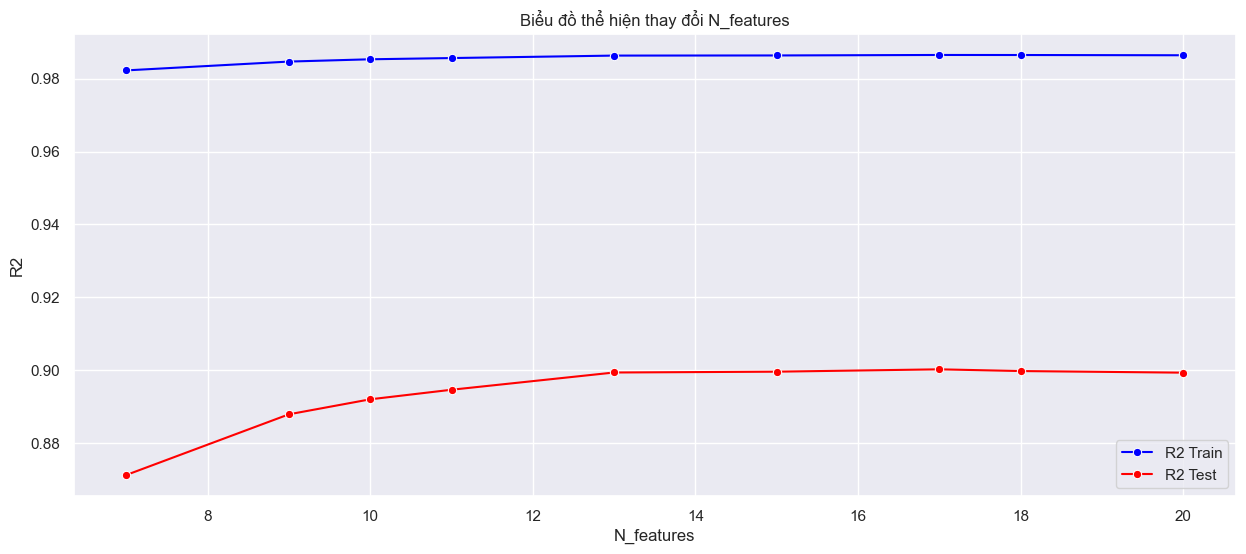

In [ ]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = n_features, y = df_features['R2_train'], label = 'R2 Train', marker = 'o', color = 'blue')
sns.lineplot(x = n_features, y = df_features['R2_test'], label = 'R2 Test', marker = 'o', color = 'red')
plt.xlabel('N_features')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.title('Biểu đồ thể hiện thay đổi N_features')
plt.show()

#### MÔ HÌNH CUỐI CÙNG

In [ ]:
reg = RandomForestRegressor(n_estimators = 140, max_depth = 36, min_samples_leaf = 1, min_samples_split = 2, max_features = 17, random_state=42)
reg.fit(x_train, y_train)
y_predict = reg.predict(x_test)
R2_train_final = reg.score(x_train, y_train)
R2_test_final = r2_score(y_test, y_predict)
MAE_final = mean_absolute_error(y_test, y_predict)
MSE_final = mean_squared_error(y_test, y_predict)
print('R2(train): ', R2_train_final)
print('R2(test): ', R2_test_final)
print('MAE: ', MAE_final)
print('MSE: ', MSE_final)

R2(train):  0.9864765507464576
R2(test):  0.9002899232578223
MAE:  612.6413143329801
MSE:  927453.8571071222


In [ ]:
df_xtrain = x_train.reset_index().copy()

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [ ]:
df_SalesPredict = pd.DataFrame(y_predict, columns=['SalesPredict'])
y_test.reset_index(drop=True, inplace=True)
predict_data = pd.concat([df_y_predict, y_test], axis=1)
df_predict_test = pd.concat([df_xtrain['Date'], predict_data], axis = 1)

In [ ]:
df_predict_test.sort_values(by = 'Date')
df_predict_test.set_index('Date', inplace = True)

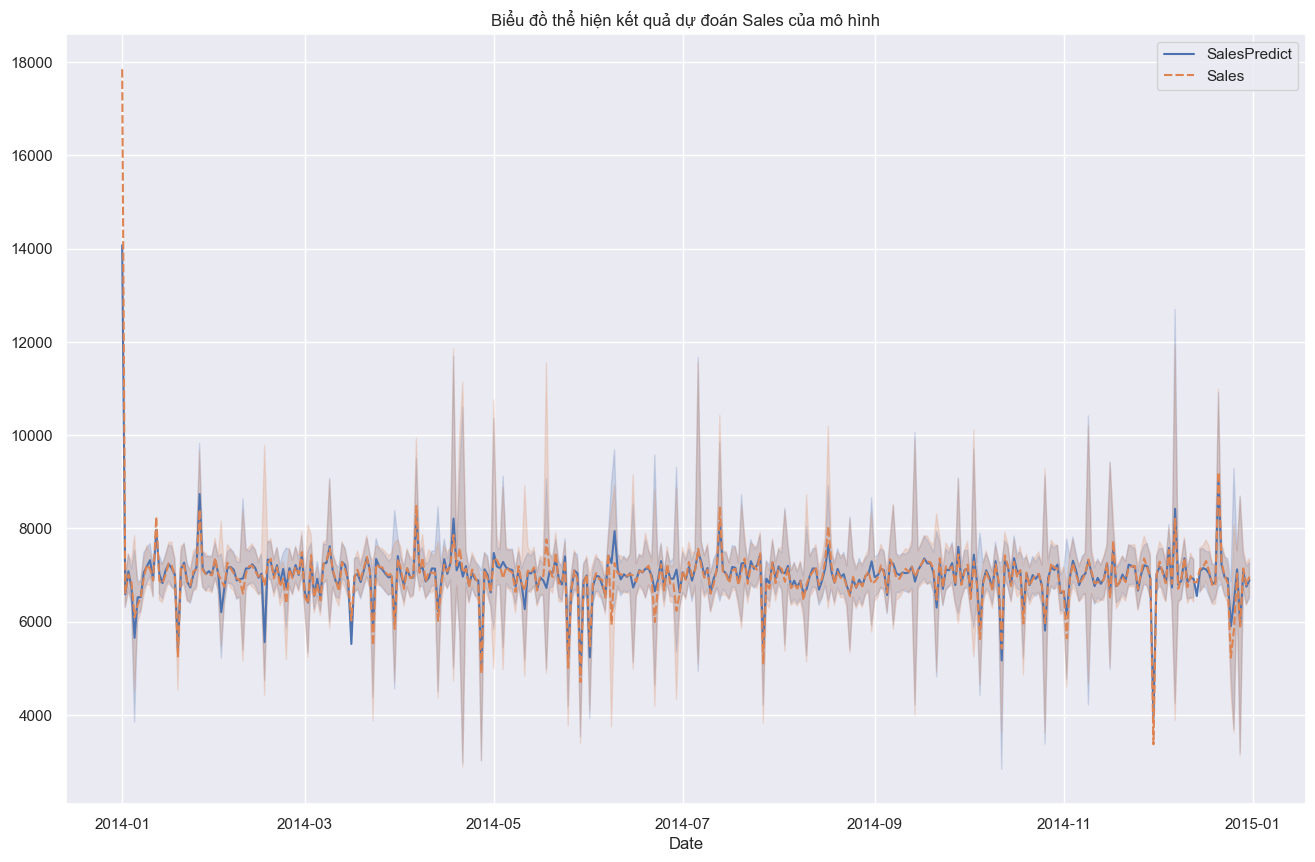

In [ ]:
plt.figure(figsize=(16, 10))
sns.lineplot(data = df_predict_test).set(title='Biểu đồ thể hiện kết quả dự đoán Sales của mô hình');
plt.show()